## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import tensorflow as tf
from keras.layers import Flatten, Dense, Input, Dropout, Conv1D, BatchNormalization, MaxPooling1D, Flatten, LSTM, Bidirectional, Embedding, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop, Adamax

import ast

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

## Data preparation

In [2]:
train_data = pd.read_csv('../../../Data/labelled_training_data.csv')
val_data = pd.read_csv('../../../Data/labelled_validation_data.csv')
test_data = pd.read_csv('../../../Data/labelled_testing_data.csv')

In [3]:
train_data["processId"] = train_data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_data["parentProcessId"] = train_data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_data["userId"] = train_data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
train_data["mountNamespace"] = train_data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
train_data["eventId"] = train_data["eventId"]  # Keep eventId values (requires knowing max value)
train_data["returnValue"] = train_data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))


val_data["processId"] = val_data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
val_data["parentProcessId"] = val_data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
val_data["userId"] = val_data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
val_data["mountNamespace"] = val_data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
val_data["eventId"] = val_data["eventId"]  # Keep eventId values (requires knowing max value)
val_data["returnValue"] = val_data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2)) 


test_data["processId"] = test_data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
test_data["parentProcessId"] = test_data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
test_data["userId"] = test_data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
test_data["mountNamespace"] = test_data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
test_data["eventId"] = test_data["eventId"]  # Keep eventId values (requires knowing max value)
test_data["returnValue"] = test_data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2)) 

In [4]:
train_data.describe()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus,evil
count,188967.000000,188967.000000,188967.000000,188967.000000,188967.000000,188967.000000,188967.000000,188967.000000,188967.000000,188967.000000,188967.000000
mean,455.070015,0.989046,7347.754089,0.950499,0.853329,0.001752,88.802198,2.894569,1.620675,0.907349,0.838411
std,61.824198,0.104088,1108.656349,0.216912,0.353779,0.041816,199.137059,0.638079,0.745558,0.289944,0.368074
min,129.050634,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,461.577225,1.000000,7555.000000,1.000000,1.000000,0.000000,42.000000,3.000000,2.000000,1.000000,1.000000
50%,470.889349,1.000000,7555.000000,1.000000,1.000000,0.000000,42.000000,3.000000,2.000000,1.000000,1.000000
75%,487.116843,1.000000,7555.000000,1.000000,1.000000,0.000000,42.000000,3.000000,2.000000,1.000000,1.000000
max,496.629091,1.000000,7705.000000,1.000000,1.000000,1.000000,1010.000000,5.000000,2.000000,1.000000,1.000000


In [5]:
train_data.dtypes

timestamp          float64
processId            int64
threadId             int64
parentProcessId      int64
userId               int64
mountNamespace       int64
processName         object
hostName            object
eventId              int64
eventName           object
stackAddresses      object
argsNum              int64
returnValue          int64
args                object
sus                  int64
evil                 int64
dtype: object

### **Stackaddress**

In [6]:
stack_addresses_df = pd.concat([train_data['stackAddresses'], val_data['stackAddresses'], test_data['stackAddresses']], axis=0)
len(stack_addresses_df.unique())

15426

**Convert String to List**

In [7]:
# Convert string to list
train_data.stackAddresses = train_data.stackAddresses.apply(ast.literal_eval)
val_data.stackAddresses = val_data.stackAddresses.apply(ast.literal_eval)
test_data.stackAddresses = test_data.stackAddresses.apply(ast.literal_eval)
train_data.stackAddresses[0]

[140159195621643, 140159192455417, 94656731598592]

In [8]:
train_data['stack_address_len']=train_data.stackAddresses.apply(len)
val_data['stack_address_len']=val_data.stackAddresses.apply(len)
test_data['stack_address_len']=test_data.stackAddresses.apply(len)
print(f"Training dataset - Max length of stack addresses: {max(train_data['stack_address_len'])}")
print(f"Validation dataset - Max length of stack addresses: {max(val_data['stack_address_len'])}")
print(f"Testing dataset - Max length of stack addresses: {max(test_data['stack_address_len'])}")

Training dataset - Max length of stack addresses: 20
Validation dataset - Max length of stack addresses: 20
Testing dataset - Max length of stack addresses: 20


In [9]:
train_data['stack_address_len'].value_counts()

stack_address_len
0     181438
2       3428
1       1991
3       1748
4        154
20        50
6         36
15        28
14        23
5         19
7         14
8         13
17         6
11         6
10         4
16         4
12         3
9          2
Name: count, dtype: int64

**Split list**

In [10]:
for i in range(max(train_data['stack_address_len'])):
    train_data[f"stack_{i+1}"]=""
    val_data[f"stack_{i+1}"]=""
    test_data[f"stack_{i+1}"]=""

In [11]:
for index, row in train_data.iterrows():
    list_stack = [float(elem) for elem in row['stackAddresses']]
    for i, elem in enumerate(list_stack):
        train_data.at[index, f'stack_{i+1}'] = elem

for index, row in val_data.iterrows():
    list_stack = [float(elem) for elem in row['stackAddresses']]
    for i, elem in enumerate(list_stack):
        val_data.at[index, f'stack_{i+1}'] = elem


for index, row in test_data.iterrows():
    list_stack = [float(elem) for elem in row['stackAddresses']]
    for i, elem in enumerate(list_stack):
        test_data.at[index, f'stack_{i+1}'] = elem

In [12]:
train_data.loc[0]

timestamp                                                   129.050634
processId                                                            1
threadId                                                           382
parentProcessId                                                      0
userId                                                               0
mountNamespace                                                       1
processName                                            systemd-resolve
hostName                                               ip-10-100-1-217
eventId                                                             41
eventName                                                       socket
stackAddresses       [140159195621643, 140159192455417, 94656731598...
argsNum                                                              3
returnValue                                                          1
args                 [{'name': 'domain', 'type': 'int', 'value': 'A...
sus   

**Args**

In [13]:
train_data['argsNum'].value_counts()

argsNum
3    148719
4     15147
2     12493
1     11707
5       708
0       193
Name: count, dtype: int64

In [14]:
len(train_data['args'].unique())

35177

In [15]:
train_data['args'][4]

"[{'name': 'fd', 'type': 'int', 'value': 17}, {'name': 'statbuf', 'type': 'struct stat*', 'value': '0x7FFE8293A360'}]"

**Split args**

In [16]:
# Function to split the string column into list of dictionaries and create new columns
def split_and_expand(row):
    if pd.isna(row):
        return pd.Series([None] * 15)

    dicts = ast.literal_eval(row)
    result = {'name_{}'.format(i+1): None for i in range(5)}
    result.update({'type_{}'.format(i+1): None for i in range(5)})
    result.update({'value_{}'.format(i+1): None for i in range(5)})

    for i, d in enumerate(dicts):
        if i >= 5:
            break
        result['name_{}'.format(i+1)] = d.get('name')
        result['type_{}'.format(i+1)] = d.get('type')
        result['value_{}'.format(i+1)] = d.get('value')

    return pd.Series(result)

Training

In [17]:
args_split = train_data['args'].apply(split_and_expand)
train_data = pd.concat([train_data, args_split], axis=1)

Validation

In [18]:
args_split = val_data['args'].apply(split_and_expand)
val_data = pd.concat([val_data, args_split], axis=1)

Testing

In [19]:
args_split = test_data['args'].apply(split_and_expand)
test_data = pd.concat([test_data, args_split], axis=1)

**Features selection**

In [20]:
# data1 = train_data.sample(frac=0.4, ignore_index=True)

X_num_train = train_data[['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'argsNum', 'returnValue', 'stack_address_len']]
X_cat_train = train_data[['processName', 'hostName', 'eventName',
                     'stack_1', 'stack_2', 'stack_3', 'stack_4',
                     'stack_5', 'stack_6', 'stack_7', 'stack_8', 'stack_9', 
                     'stack_10','stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                     'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20',
                     'name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                     'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                     'value_1', 'value_2', 'value_3', 'value_4', 'value_5']].astype(str)

In [21]:
X_num_val = val_data[['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'argsNum', 'returnValue', 'stack_address_len']]
X_cat_val = val_data[['processName', 'hostName', 'eventName',
                     'stack_1', 'stack_2', 'stack_3', 'stack_4',
                     'stack_5', 'stack_6', 'stack_7', 'stack_8', 'stack_9', 
                     'stack_10','stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                     'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20',
                     'name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                     'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                     'value_1', 'value_2', 'value_3', 'value_4', 'value_5']].astype(str)

In [22]:
X_num_test = test_data[['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'argsNum', 'returnValue', 'stack_address_len']]
X_cat_test = test_data[['processName', 'hostName', 'eventName',
                     'stack_1', 'stack_2', 'stack_3', 'stack_4',
                     'stack_5', 'stack_6', 'stack_7', 'stack_8', 'stack_9', 
                     'stack_10','stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                     'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20',
                     'name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                     'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                     'value_1', 'value_2', 'value_3', 'value_4', 'value_5']].astype(str)

**Categorical features encoding**

Stack addresses

In [23]:
stack_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', 
                                 unknown_value=-1, dtype=float)

# Encode Stack adresses
stackaddresses_train_enc = stack_ordinal_encoder.fit_transform(X_cat_train[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                                                      'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                                                      'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                                                      'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']])

In [24]:
X_cat_train[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
             'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
             'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
             'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']] = stackaddresses_train_enc

In [25]:
stackaddresses_val_enc = stack_ordinal_encoder.transform(X_cat_val[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                                        'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                                        'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                                        'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']])

In [26]:
stackaddresses_val_enc = np.where(stackaddresses_val_enc==-1, np.max(stackaddresses_train_enc)+1, stackaddresses_val_enc)

In [27]:
X_cat_val[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
           'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
           'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
           'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']]= stackaddresses_val_enc

In [28]:
stackaddresses_test_enc = stack_ordinal_encoder.transform(X_cat_test[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                                        'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                                        'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                                        'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']])

stackaddresses_test_enc = np.where(stackaddresses_test_enc==-1, np.max(stackaddresses_train_enc)+1, stackaddresses_test_enc)

X_cat_test[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
           'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
           'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
           'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']]= stackaddresses_test_enc

Args

In [29]:
# Encode Stack adresses
args_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=float)
args_train_enc = args_ordinal_encoder.fit_transform(X_cat_train[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                                            'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                                            'value_1', 'value_2', 'value_3', 'value_4', 'value_5']])
X_cat_train[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
             'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
             'value_1', 'value_2', 'value_3', 'value_4', 'value_5']] = args_train_enc

In [30]:
args_val_enc = args_ordinal_encoder.transform(X_cat_val[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                                    'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                                    'value_1', 'value_2', 'value_3', 'value_4', 'value_5']])

args_val_enc = np.where(args_val_enc==-1, np.max(args_train_enc)+1, args_val_enc)

X_cat_val[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
           'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
           'value_1', 'value_2', 'value_3', 'value_4', 'value_5']] = args_val_enc

In [31]:
args_test_enc = args_ordinal_encoder.transform(X_cat_test[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                                      'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                                      'value_1', 'value_2', 'value_3', 'value_4', 'value_5']])

args_test_enc = np.where(args_test_enc==-1, np.max(args_train_enc)+1, args_test_enc)

X_cat_test[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
           'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
           'value_1', 'value_2', 'value_3', 'value_4', 'value_5']] = args_test_enc

ProcessName

In [32]:
proc_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=float)
X_cat_train['processName'] = proc_ordinal_encoder.fit_transform(X_cat_train[['processName']])

In [33]:
processName_val_enc = proc_ordinal_encoder.transform(X_cat_val[['processName']])
processName_val_enc = np.where(processName_val_enc==-1, np.max(X_cat_train['processName'])+1, processName_val_enc)
X_cat_val['processName'] = processName_val_enc

In [34]:
processName_test_enc = proc_ordinal_encoder.transform(X_cat_test[['processName']])
processName_test_enc = np.where(processName_test_enc==-1, np.max(X_cat_train['processName'])+1, processName_test_enc)
X_cat_test['processName'] = processName_test_enc

HostName

In [35]:
host_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=float)
X_cat_train['hostName'] = host_ordinal_encoder.fit_transform(X_cat_train[['hostName']])

host_val_enc = host_ordinal_encoder.transform(X_cat_val[['hostName']])
host_val_enc = np.where(host_val_enc==-1, np.max(X_cat_train['hostName'])+1, host_val_enc)
X_cat_val['hostName'] = host_val_enc

host_test_enc = host_ordinal_encoder.transform(X_cat_test[['hostName']])
host_test_enc = np.where(host_test_enc==-1, np.max(X_cat_train['hostName'])+1, host_test_enc)
X_cat_test['hostName'] = host_test_enc

EventName

In [36]:
event_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=float)
X_cat_train['eventName'] = event_ordinal_encoder.fit_transform(X_cat_train[['eventName']])

event_val_enc = event_ordinal_encoder.transform(X_cat_val[['eventName']])
event_val_enc = np.where(event_val_enc==-1, np.max(X_cat_train['eventName'])+1, event_val_enc)
X_cat_val['eventName'] = event_val_enc

event_test_enc = event_ordinal_encoder.transform(X_cat_test[['eventName']])
event_test_enc = np.where(event_test_enc==-1, np.max(X_cat_train['eventName'])+1, event_test_enc)
X_cat_test['eventName'] = event_test_enc

In [37]:
X_train = pd.concat([X_num_train, X_cat_train], axis=1)
y_train = train_data['sus']

In [38]:
X_val = pd.concat([X_num_val, X_cat_val], axis=1)
y_val = val_data['sus']

In [39]:
X_test = pd.concat([X_num_test, X_cat_test], axis=1)
y_test = test_data['sus']

## Modelisation

#### Plot training history

In [40]:
def plot_training(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Get the training and validation loss
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Plot the accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot the loss
    plt.figure(figsize=(8, 4))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    return(plt)

#### <b>Model1 no embeddings</b>

In [50]:
random_normal_initializer = tf.keras.initializers.RandomNormal(mean=0.1, stddev=0.1, seed=51)
model1 = Sequential([
  LSTM(32, input_shape=(47, 1), activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  LSTM(32, activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  LSTM(32, activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  LSTM(32, activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  Flatten(),
  Dense(units=128, activation='relu', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer),
  Dense(units=1, activation='sigmoid', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer)
])

model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 47, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 47, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 47, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 47, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 47, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 47, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 47, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 47, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1504)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       192,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,081 (867.50 KB)

 Trainable params: 222,081 (867.50 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=False)
history1 = model1.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=100, verbose=1, batch_size=10000,
                      callbacks=[callback])


# Model evaluation
accuracy1 = model1.evaluate(X_test,y_test)
print(f"Accuracy of model1: {(100*accuracy1[1]):.1f}%")

Epoch 1/100


19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7836 - loss: 100.0254 - val_accuracy: 0.1888 - val_loss: 242.1802
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8680 - loss: 21.4032 - val_accuracy: 0.2684 - val_loss: 72.8662
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8194 - loss: 16.8562 - val_accuracy: 0.0864 - val_loss: 27.3994
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8628 - loss: 5.3860 - val_accuracy: 0.0339 - val_loss: 12.7830
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8869 - loss: 2.6376 - val_accuracy: 0.0210 - val_loss: 5.5138
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9029 - loss: 1.2734 - val_accuracy: 0.0196 - val_loss: 5.2545
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9054 - loss: 0.8839 - val_accuracy: 0.0204 - val_loss: 3.0343
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.7398 - loss: 0.7920
Accuracy of the second model: 91.0%


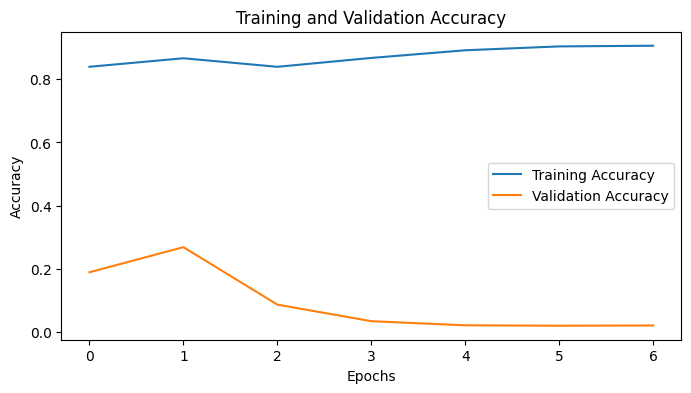

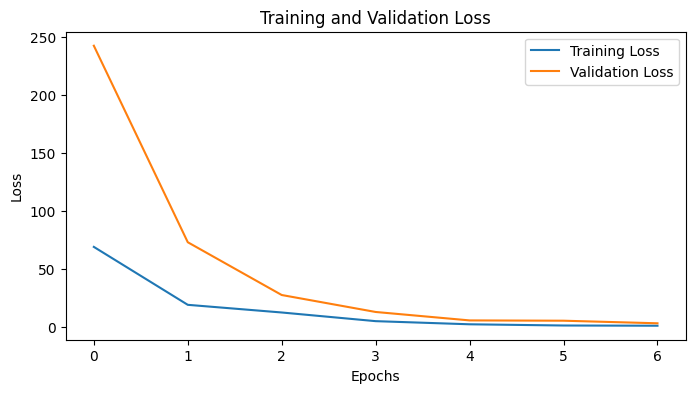

In [52]:
plot_training(history1);

##### <b>Prediction</b>

In [53]:
prediction_1 = model1.predict(X_test)
prediction_1_threshold = np.where(prediction_1>0.5,1,0)

5906/5906 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step


##### <b>F1 score</b>

In [54]:
print(classification_report(y_test, prediction_1_threshold))

              precision    recall  f1-score   support

           0       0.97      0.03      0.06     17508
           1       0.91      1.00      0.95    171459

    accuracy                           0.91    188967
   macro avg       0.94      0.52      0.51    188967
weighted avg       0.92      0.91      0.87    188967



##### **Confusion matrix**

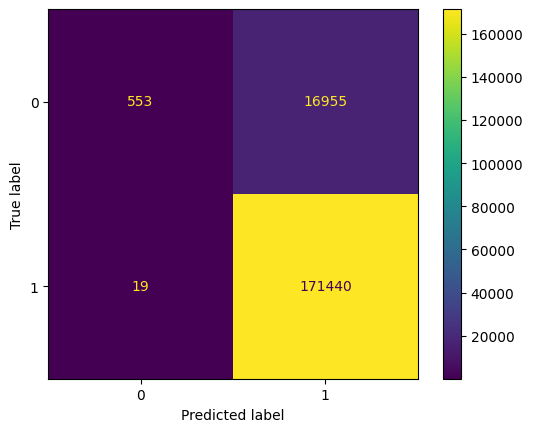

In [55]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=prediction_1_threshold)
ConfusionMatrixDisplay(conf_matrix).plot()

##### <b>AUC</b>

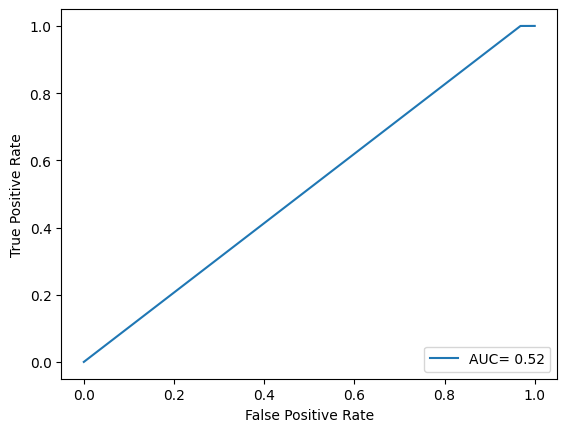

In [56]:
auroc = roc_auc_score(y_test, prediction_1_threshold)
fpr, tpr, _ = roc_curve(y_test, prediction_1_threshold)
plt.plot(fpr,tpr,label=f"AUC= {auroc:.2f}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

#### **Model2 with embeddings for categorical features**

**Model**

In [57]:
n_unique_stack = (np.max(stackaddresses_train_enc)+2).astype('int')
n_unique_args = (np.max(args_train_enc)+2).astype('int')
n_unique_proc = (np.max(X_cat_train['processName'])+2).astype('int')
n_unique_event = (np.max(X_cat_train['eventName'])+2).astype('int')
n_unique_host = (np.max(X_cat_train['hostName'])+2).astype('int')

n_unique_stack,n_unique_args,n_unique_proc,n_unique_event,n_unique_host

(1302, 23903, 245, 47, 2)

In [58]:
# Define input layers
input_stack = Input(shape=(20,))
input_args = Input(shape=(15,))
input_proc = Input(shape=(1,))
input_event = Input(shape=(1,))
input_host = Input(shape=(1,))
input_num = Input(shape=(9,))

input_layers = [input_stack, input_args, input_proc, input_event, input_host, input_num]

# Embeddings
embedding_stack = Embedding(input_dim=n_unique_stack, output_dim=512, name="stack_addresses")(input_stack)
embedding_args = Embedding(input_dim=n_unique_args, output_dim=512, name="args")(input_args)
embedding_proc = Embedding(input_dim=n_unique_proc, output_dim=512, name="process_name")(input_proc)
embedding_event = Embedding(input_dim=n_unique_event, output_dim=512, name="event_name")(input_event)
embedding_host = Embedding(input_dim=n_unique_host, output_dim=512, name="host_name")(input_host)

# Reshape embeddings
embedding_stack_reshape = Reshape(target_shape=(20, 512))(embedding_stack)
embedding_args_reshape = Reshape(target_shape=(15, 512))(embedding_args)

# Concatenate embeddings
embedding_concat = Concatenate(axis=1)([embedding_stack_reshape, embedding_args_reshape, 
                                        embedding_proc, embedding_event, embedding_host])

random_normal_initializer = tf.keras.initializers.RandomNormal(mean=0.1, stddev=0.1, seed=51)

# LSTM layers
lstm1 = LSTM(256, activation='relu', kernel_initializer='lecun_normal',
             bias_initializer=random_normal_initializer, return_sequences=True)(embedding_concat)
lstm2 = LSTM(128, activation='relu', kernel_initializer='lecun_normal',
             bias_initializer=random_normal_initializer, return_sequences=True)(lstm1)
lstm3 = LSTM(16, activation='relu', kernel_initializer='lecun_normal',
             bias_initializer=random_normal_initializer, return_sequences=True)(lstm2)
flatten = Flatten()(lstm3)

# Concatenate with numerical features
concatenated = Concatenate()([flatten, input_num])

# Dense layers
x = Dense(64, activation='relu', kernel_initializer='lecun_normal')(concatenated)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_initializer='lecun_normal')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_initializer='lecun_normal')(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(1, activation='sigmoid', kernel_initializer='lecun_normal')(x)

# Create model
model_2 = Model(inputs=input_layers, outputs=output)

In [59]:
model_2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_addresses     │ (None, 20, 512)   │    666,624 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ args (Embedding)    │ (None, 15, 512)   │ 12,238,336 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 20, 512)   │          0 │ stack_addresses[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 15, 512)   │          0 │ args[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ process_name        │ (None, 1, 512)    │    125,440 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ event_name          │ (None, 1, 512)    │     24,064 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ host_name           │ (None, 1, 512)    │      1,024 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38, 512)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ reshape_1[0][0],  │
│                     │                   │            │ process_name[0][… │
│                     │                   │            │ event_name[0][0], │
│                     │                   │            │ host_name[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 38, 256)   │    787,456 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 38, 128)   │    197,120 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 38, 16)    │      9,280 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 608)       │          0 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                 

 Total params: 14,105,537 (53.81 MB)

 Trainable params: 14,105,537 (53.81 MB)

 Non-trainable params: 0 (0.00 B)

**Training**

In [60]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=False)
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history2 = model_2.fit([X_cat_train[['stack_1','stack_2','stack_3','stack_4','stack_5',
                                  'stack_6','stack_7','stack_8','stack_9','stack_10',
                                  'stack_11','stack_12','stack_13','stack_14','stack_15',
                                  'stack_16','stack_17','stack_18','stack_19','stack_20']],
                     X_cat_train[['name_1','name_2','name_3','name_4','name_5',
                                  'type_1','type_2','type_3','type_4','type_5',
                                  'value_1','value_2','value_3','value_4','value_5']],
                     X_cat_train['processName'],
                     X_cat_train['eventName'],
                     X_cat_train['hostName'],
                     X_num_train],y_train, 
                    validation_data=([X_cat_val[['stack_1','stack_2','stack_3','stack_4','stack_5',
                                                 'stack_6','stack_7','stack_8','stack_9','stack_10',
                                                 'stack_11','stack_12','stack_13','stack_14','stack_15',
                                                 'stack_16','stack_17','stack_18','stack_19','stack_20']],
                                      X_cat_val[['name_1','name_2','name_3','name_4','name_5',
                                                 'type_1','type_2','type_3','type_4','type_5',
                                                 'value_1','value_2','value_3','value_4','value_5']],
                                      X_cat_val['processName'],
                                      X_cat_val['eventName'],
                                      X_cat_val['hostName'],
                                      X_num_val], y_val),
                    epochs=20, verbose=1, batch_size=5120, callbacks=[callback])

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.6721 - loss: 66.8610 - val_accuracy: 0.0042 - val_loss: 1241.0580
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.8886 - loss: 55.2818 - val_accuracy: 0.0454 - val_loss: 14.1836
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.8492 - loss: 1.6708 - val_accuracy: 0.0622 - val_loss: 1.8270
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.8985 - loss: 0.3306 - val_accuracy: 0.0619 - val_loss: 1.2034
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.9076 - loss: 0.2787 - val_accuracy: 0.0610 - val_loss: 1.3770
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.9124 - loss: 0.2514 - val_accuracy: 0.0611 - val_loss: 1.5923
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.9151 - loss: 0.2545 - val_accuracy: 0.0610 - val_loss: 1.6026
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.9178 - loss: 0.2368 - val_accuracy: 0.06

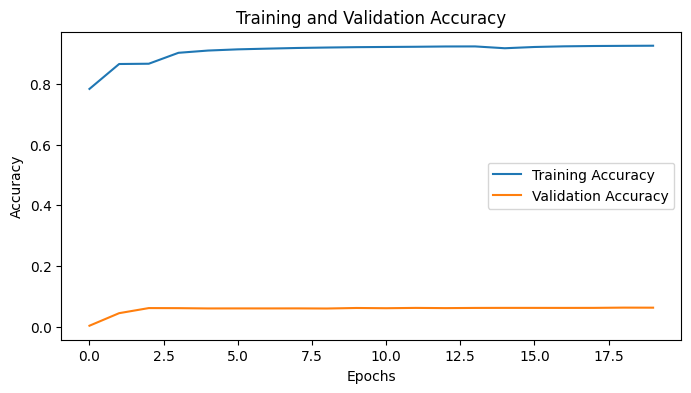

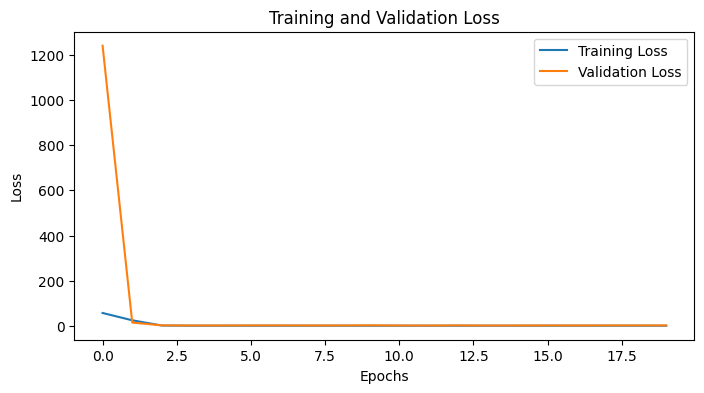

In [61]:
plot_training(history2);

**Prediction**

In [62]:
prediction_2 = model_2.predict([X_cat_test[['stack_1','stack_2','stack_3','stack_4','stack_5',
                                  'stack_6','stack_7','stack_8','stack_9','stack_10',
                                  'stack_11','stack_12','stack_13','stack_14','stack_15',
                                  'stack_16','stack_17','stack_18','stack_19','stack_20']],
                     X_cat_test[['name_1','name_2','name_3','name_4','name_5',
                                  'type_1','type_2','type_3','type_4','type_5',
                                  'value_1','value_2','value_3','value_4','value_5']],
                     X_cat_test['processName'],
                     X_cat_test['eventName'],
                     X_cat_test['hostName'],
                     X_num_test])

5906/5906 ━━━━━━━━━━━━━━━━━━━━ 252s 43ms/step


In [73]:
prediction_2_threshold = np.where(prediction_2>0.5,1,0)

Classification report

In [74]:
print(classification_report(y_test, prediction_2_threshold))

              precision    recall  f1-score   support

           0       1.00      0.23      0.37     17508
           1       0.93      1.00      0.96    171459

    accuracy                           0.93    188967
   macro avg       0.96      0.61      0.67    188967
weighted avg       0.93      0.93      0.91    188967



Confusion matrix

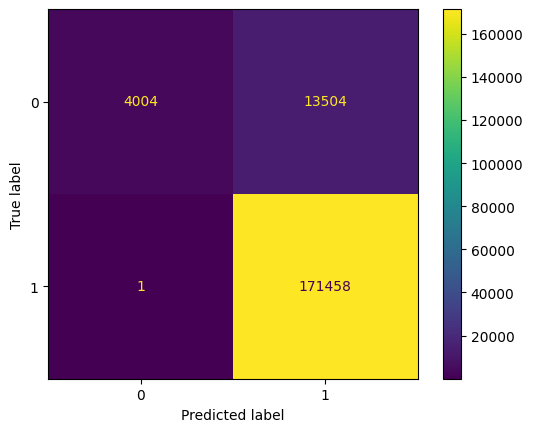

In [75]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=prediction_2_threshold)
ConfusionMatrixDisplay(conf_matrix).plot()

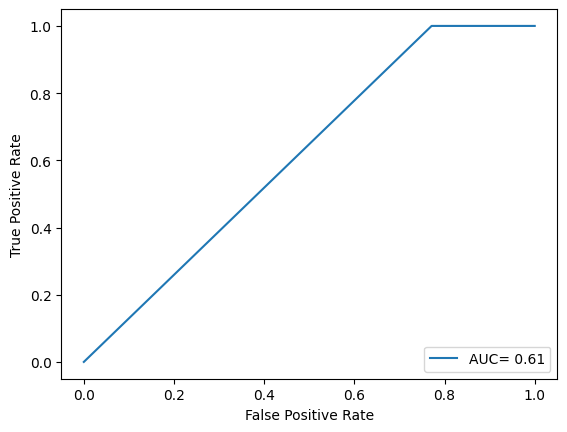

In [76]:
auroc = roc_auc_score(y_true=y_test, y_score=prediction_2_threshold)
fpr, tpr, _ = roc_curve(y_test, prediction_2_threshold)
plt.plot(fpr,tpr,label=f"AUC= {auroc:.2f}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Save the model

In [251]:
# model_conv_emb.save('Conv_model_embeddings.keras')